# <div align="center"><b>Differential expression analysis with DESeq2</b></div>

In [1]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import decoupler as dc

In [3]:
path_counts = "/tscc/nfs/home/aklie/scratch/feature_counts/hangauer.results.counts"
path_out = '/tscc/nfs/home/aklie/scratch/differential_analysis'

In [ ]:
%%bash 
mkdir -p path_out

# Load data

In [9]:
# Load counts_df
counts_df = pd.read_csv(path_counts, comment="#", sep="\t", index_col=0)
gene_info = counts_df.iloc[:, 0:5]
counts_df = counts_df.iloc[:, 5:]
counts_df = counts_df.rename(
    columns=
    {
        counts_df.columns[0]:"Parental1",
        counts_df.columns[1]:"Parental2",
        counts_df.columns[2]:"Persister1",
        counts_df.columns[3]:"Persister2",
        counts_df.columns[4]:"Persister3"
    }
)
counts_df = counts_df.T
counts_df.head()

Geneid,ENSG00000223972.4,ENSG00000227232.4,ENSG00000243485.2,ENSG00000237613.2,ENSG00000268020.2,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.2,ENSG00000239945.1,ENSG00000233750.3,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
Parental1,0,16,0,0,0,0,0,0,0,0,...,547601,233,254,610,227703,64091,0,339651,461,1340
Parental2,0,19,0,0,0,0,0,0,0,0,...,529945,256,281,619,222393,59832,0,327580,476,1247
Persister1,0,44,0,0,0,0,0,0,0,0,...,589636,177,224,600,419478,129461,0,472990,311,2131
Persister2,0,38,0,0,0,0,0,0,0,2,...,663380,199,193,525,508600,149216,0,502605,302,2119
Persister3,0,61,0,0,0,0,0,0,0,7,...,604888,209,232,597,416449,130704,0,453611,267,1976


In [14]:
# Create metadata with condition
metadata = pd.DataFrame(index=counts_df.index)
metadata["condition"] = metadata.index.str[:-1]
metadata["replicate"] = metadata.index.str[-1]
metadata

,condition,replicate
Parental1,Parental,1
Parental2,Parental,2
Persister1,Persister,1
Persister2,Persister,2
Persister3,Persister,3


In [15]:
# Filtering
samples_to_keep = ~metadata.condition.isna().values
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

In [16]:
# Filter genes
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [17]:
inference = DefaultInference(n_cpus=8)

In [18]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [19]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 18.99 seconds.

Fitting dispersion trend curve...
... done in 0.44 seconds.

/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 21.49 seconds.

Fitting LFCs...
... done in 10.85 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



In [20]:
stat_res = DeseqStats(dds, inference=inference, contrast=["condition", "Persister", "Parental"])

In [21]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Persister vs Parental
                        baseMean  log2FoldChange     lfcSE       stat  \
Geneid                                                                  
ENSG00000227232.4      35.027741        1.337082  0.410239   3.259280   
ENSG00000237683.5      59.995128        0.842590  0.296633   2.840513   
ENSG00000241860.2      28.423092        1.178053  0.438898   2.684118   
ENSG00000237094.7      87.465975        0.425554  0.239653   1.775712   
ENSG00000231709.1       2.337062        0.871877  1.457741   0.598102   
...                          ...             ...       ...        ...   
ENSG00000198786.2  352348.018934        0.875386  0.055299  15.830037   
ENSG00000198695.2  104638.946975        1.022330  0.049602  20.610859   
ENSG00000198727.2  414650.693987        0.399320  0.048241   8.277646   
ENSG00000210195.2     365.322118       -0.789284  0.123507  -6.390608   
ENSG00000210196.2    1741.077500        0.568739  0.07

... done in 4.09 seconds.



In [22]:
res = stat_res.results_df

In [23]:
res["ensembl_gene_id"] = res.index.str.split(".").str[0]

In [24]:
from sanbomics.tools import id_map
mapper = id_map(species = 'human')
res['Symbol'] = res["ensembl_gene_id"].map(mapper.mapper) 
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,Symbol
Geneid,,,,,,,,
ENSG00000227232.4,35.027741,1.337082,0.410239,3.259280,1.116954e-03,2.536477e-03,ENSG00000227232,WASH7P
ENSG00000237683.5,59.995128,0.842590,0.296633,2.840513,4.504105e-03,9.338183e-03,ENSG00000237683,NaN
ENSG00000241860.2,28.423092,1.178053,0.438898,2.684118,7.272149e-03,1.462443e-02,ENSG00000241860,AL627309.5
ENSG00000237094.7,87.465975,0.425554,0.239653,1.775712,7.578044e-02,1.226871e-01,ENSG00000237094,NaN
ENSG00000231709.1,2.337062,0.871877,1.457741,0.598102,5.497721e-01,NaN,ENSG00000231709,NaN
...,...,...,...,...,...,...,...,...
ENSG00000198786.2,352348.018934,0.875386,0.055299,15.830037,1.931070e-56,3.604610e-55,ENSG00000198786,MT-ND5
ENSG00000198695.2,104638.946975,1.022330,0.049602,20.610859,2.193063e-94,8.050630e-93,ENSG00000198695,MT-ND6
ENSG00000198727.2,414650.693987,0.399320,0.048241,8.277646,1.256343e-16,6.812756e-16,ENSG00000198727,MT-CYB


In [25]:
res = res[res.baseMean >= 10]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,Symbol
Geneid,,,,,,,,
ENSG00000227232.4,35.027741,1.337082,0.410239,3.259280,1.116954e-03,2.536477e-03,ENSG00000227232,WASH7P
ENSG00000237683.5,59.995128,0.842590,0.296633,2.840513,4.504105e-03,9.338183e-03,ENSG00000237683,NaN
ENSG00000241860.2,28.423092,1.178053,0.438898,2.684118,7.272149e-03,1.462443e-02,ENSG00000241860,AL627309.5
ENSG00000237094.7,87.465975,0.425554,0.239653,1.775712,7.578044e-02,1.226871e-01,ENSG00000237094,NaN
ENSG00000225972.1,46.995998,-0.774459,0.309139,-2.505212,1.223780e-02,2.361121e-02,ENSG00000225972,MTND1P23
...,...,...,...,...,...,...,...,...
ENSG00000198786.2,352348.018934,0.875386,0.055299,15.830037,1.931070e-56,3.604610e-55,ENSG00000198786,MT-ND5
ENSG00000198695.2,104638.946975,1.022330,0.049602,20.610859,2.193063e-94,8.050630e-93,ENSG00000198695,MT-ND6
ENSG00000198727.2,414650.693987,0.399320,0.048241,8.277646,1.256343e-16,6.812756e-16,ENSG00000198727,MT-CYB


In [26]:
res.to_csv(f"{path_out}/deseq2_results.csv")

In [27]:
sigs = res[(res.padj < 0.001) & (abs(res.log2FoldChange) > 2)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ensembl_gene_id,Symbol
Geneid,,,,,,,,
ENSG00000187634.6,440.538965,2.042904,0.145699,14.021397,1.153215e-44,1.587855e-43,ENSG00000187634,SAMD11
ENSG00000215912.7,24.390270,2.830551,0.593320,4.770701,1.835861e-06,5.445668e-06,ENSG00000215912,TTC34
ENSG00000238260.1,27.025558,2.846320,0.570950,4.985232,6.188763e-07,1.905948e-06,ENSG00000238260,AL513320.1
ENSG00000097021.15,889.739888,-2.328068,0.091795,-25.361636,6.687361e-142,4.237706e-140,ENSG00000097021,ACOT7
ENSG00000183888.4,667.445238,-2.106793,0.097975,-21.503476,1.444537e-102,5.926107e-101,ENSG00000183888,SRARP
...,...,...,...,...,...,...,...,...
ENSG00000133124.10,18.040930,3.783391,0.843517,4.485260,7.282503e-06,2.063329e-05,ENSG00000133124,IRS4
ENSG00000237863.2,20.915884,4.432325,0.922688,4.803710,1.557524e-06,4.653313e-06,ENSG00000237863,IRS4-AS1
ENSG00000203952.5,29.841806,-4.300151,0.560094,-7.677548,1.621630e-14,7.906436e-14,ENSG00000203952,CCDC160


In [28]:
import scanpy as sc

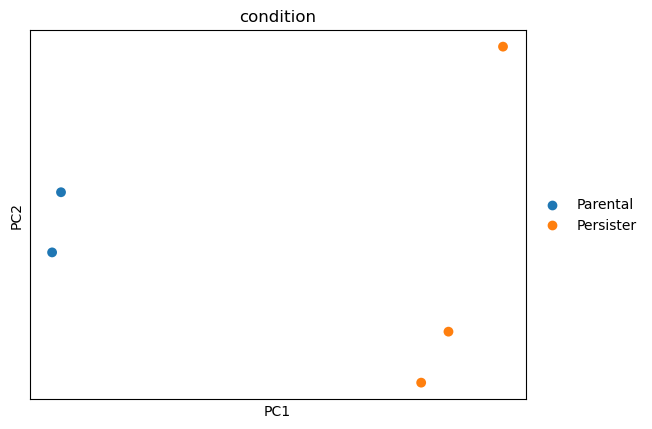

In [29]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = 'condition', size = 200)

In [30]:
dds

AnnData object with n_obs × n_vars = 5 × 24350
    obs: 'condition', 'replicate'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable', 'X_pca'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
    layers: 'normed_counts', '_mu_hat', 'cooks'

# Viz

In [31]:
res["Geneid"] = res.index
res = res.set_index("Symbol")

/tmp/ipykernel_1374384/3264297959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["Geneid"] = res.index


/tscc/nfs/home/aklie/opt/miniconda3/envs/2024-mstp-bootcamp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


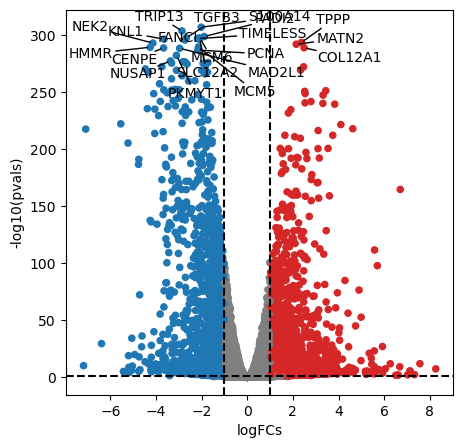

In [32]:
dc.plot_volcano_df(
    res,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(5, 5),
    sign_thr=0.05,
    lFCs_thr=1,
)

In [33]:
import numpy as np

In [34]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

In [35]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 5 × 1104
    obs: 'condition', 'replicate'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'condition_colors'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable', 'X_pca'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [36]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

In [37]:
import seaborn as sns

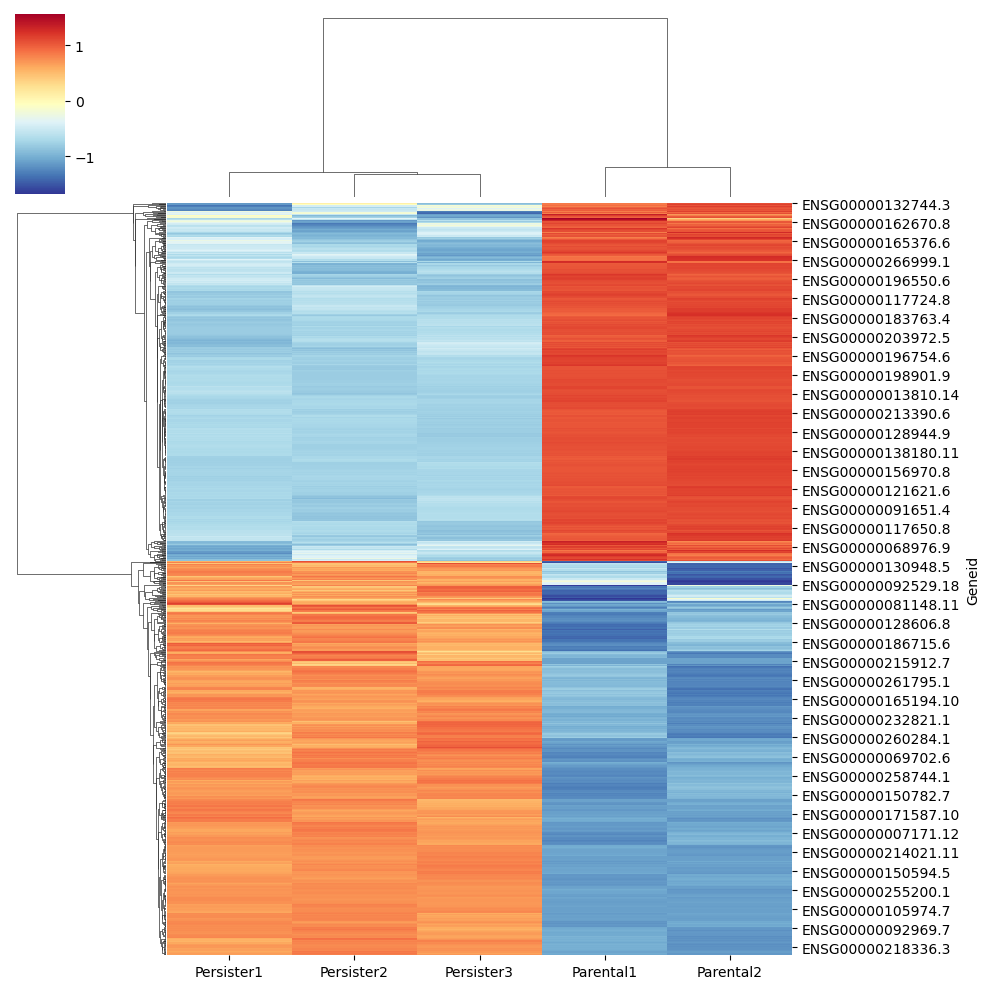

In [38]:
sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')